# Exploratory Data Analysis for Household Energy Consumption


## EDA Checklist

1. What's the resolution? 
Ans. 30 min intervals ==> 48 steps/day
2. Is data regular? Any missing timestamps or misaligned intervals? Are there missing intervals that are systemic(eg nights off)?
Ans. The dataset is very large and it is very difficult to check for this one without kernel crash. Discuss it with group members on how to move forward.
3. How long is each time series(per household)? Find longest/shortest series. 
Ans. Not regular from even only comparing a few households. Also years don't match and the amount of days avaiable doesn't match. Discuss it with group members because it will be important for input sequence length, sampling frequence, padding strategy. 
4. Is there any cyclical features? How about seasonality? How about time-of-day trends?(peak in morning/evening) Important for deciding whether to encode time features(hour,day, month) or use positional encodings or learned embeddings

5. Variability Across households: compare patterns across different IDs. Do some households have much higher/steadier usage? "Consider normalizing per household or modeling them independently."


In [34]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

For AUS:
1. Added columns time, date, hour_min
2. There are 13735 many households dataset in AUS
3. Date range for AUS: 2011-10-06 12:30:00 to 2014-03-04 08:00:00
4. Choose 4 households in AUS and created df_subset_of_4
5. Do the EDA for those.

In [35]:
df_30m_aus = dd.read_parquet("TUDelft-Electricity-Consumption-1.0/30m_resolution_aus/aus_30m.parquet")
#df_30m_aus["datetime"] = dd.to_datetime(df_30m_aus["datetime"])
#df_30m_aus["time"] = df_30m_aus["datetime"].dt.time
#df_30m_aus["date"] = df_30m_aus["datetime"].dt.date
#df_30m_aus['hour_min'] = df_30m_aus["datetime"].dt.strftime("%H:%M")

In [36]:
df_30m_aus.dtypes  
df_30m_aus.columns  

Index(['datetime', 'id', 'target', 'category'], dtype='object')

In [4]:
df_30m_aus.head(10)

,datetime,id,target,category
0,2012-02-10 08:00:00,AUS_10006414,0.141,30m
1,2012-02-10 08:30:00,AUS_10006414,0.088,30m
2,2012-02-10 09:00:00,AUS_10006414,0.078,30m
3,2012-02-10 09:30:00,AUS_10006414,0.151,30m
4,2012-02-10 10:00:00,AUS_10006414,0.146,30m
5,2012-02-10 10:30:00,AUS_10006414,0.077,30m
6,2012-02-10 11:00:00,AUS_10006414,0.052,30m
7,2012-02-10 11:30:00,AUS_10006414,0.055,30m
8,2012-02-10 12:00:00,AUS_10006414,0.055,30m
9,2012-02-10 12:30:00,AUS_10006414,0.252,30m


In [5]:
n_households_aus = df_30m_aus["id"].nunique().compute()
print(f"Number of unique AUS households: {n_households_aus}")

Number of unique AUS households: 13735


In [6]:
min_date = df_30m_aus["datetime"].min().compute()
max_date = df_30m_aus["datetime"].max().compute()
print(f"Date range for AUS: {min_date} to {max_date}")

Date range for AUS: 2011-10-06 12:30:00 to 2014-03-04 08:00:00


In [16]:
print(len(df_30m_aus[df_30m_aus["id"]== "AUS_10006414"]))
print(len(df_30m_aus[df_30m_aus['id']== "AUS_10006486"]))
print(len(df_30m_aus[df_30m_aus['id']== "AUS_10006492"]))
print(len(df_30m_aus[df_30m_aus['id']== "AUS_10006572"]))

36105
18434
18434
33700


In [37]:
df_subset = df_30m_aus.head(140000)

In [38]:
df_30m_aus_subset_of_4= df_subset[df_subset["id"].isin(["AUS_10006414", "AUS_10006486","AUS_10006492","AUS_10006572"])]

In [40]:
df_30m_aus_subset_of_4.to_csv("data/df_30m_subset_of_4.csv", index= False)

In [41]:
print(df_30m_aus_subset_of_4.info())
print(df_30m_aus_subset_of_4.describe())
print(df_30m_aus_subset_of_4["id"].value_counts())


<class 'pandas.core.frame.DataFrame'>
Index: 106673 entries, 0 to 106672
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   datetime  106673 non-null  datetime64[ns]
 1   id        106673 non-null  string        
 2   target    106617 non-null  float64       
 3   category  106673 non-null  string        
dtypes: datetime64[ns](1), float64(1), string(2)
memory usage: 5.6 MB
None
                            datetime         target
count                         106673  106617.000000
mean   2013-05-02 20:14:26.918526464       0.155698
min              2012-02-10 08:00:00       0.000000
25%              2012-12-09 02:00:00       0.052000
50%              2013-05-29 14:30:00       0.092000
75%              2013-10-15 11:00:00       0.202000
max              2014-03-03 10:00:00       2.281000
std                              NaN       0.172389
id
AUS_10006414    36105
AUS_10006572    33700
AUS_10006486    18434
A

In [42]:
print("Start date:", df_30m_aus_subset_of_4["datetime"].min())
print("End date:", df_30m_aus_subset_of_4["datetime"].max())


Start date: 2012-02-10 08:00:00
End date: 2014-03-03 10:00:00


In [44]:
df = df_30m_aus_subset_of_4.copy()
df["datetime"] = pd.to_datetime(df["datetime"])
df["hour"] = df["datetime"].dt.hour
df["dayofweek"] = df["datetime"].dt.dayofweek
df["month"] = df["datetime"].dt.month
df["date"] = df["datetime"].dt.date

In [45]:
summary = df.groupby("id")["target"].agg(["count", "mean", "std", "min", "max"])
print("Household Time Series Summary:")
print(summary)

Household Time Series Summary:
              count      mean       std    min    max
id                                                   
AUS_10006414  36061  0.185689  0.185222  0.000  1.837
AUS_10006486  18432  0.119283  0.170571  0.000  1.998
AUS_10006492  18428  0.131467  0.187114  0.003  2.281
AUS_10006572  33696  0.156774  0.142285  0.000  1.698


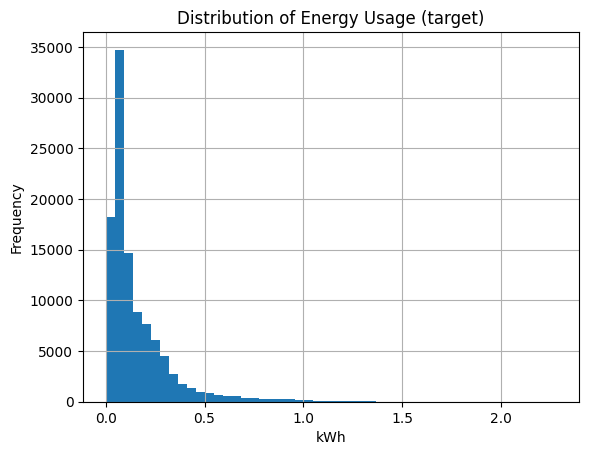

In [47]:
# Target distrubition
df["target"].hist(bins=50)
plt.title("Distribution of Energy Usage (target)")
plt.xlabel("kWh")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

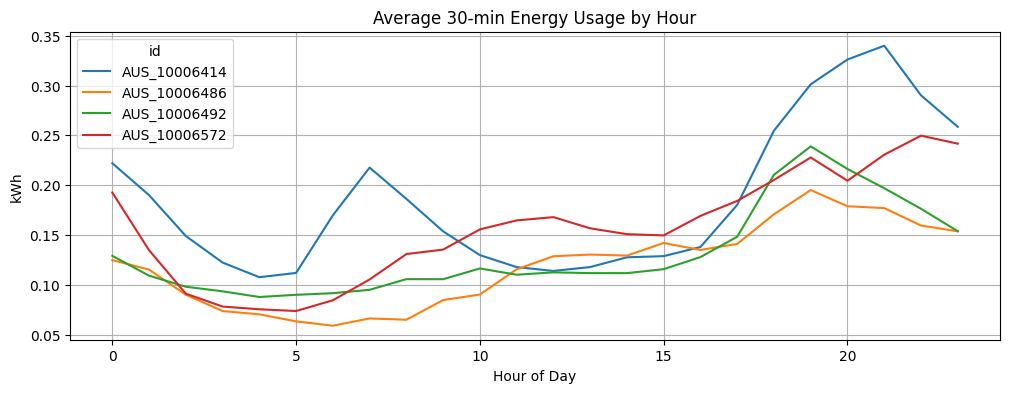

In [48]:
# Plot daily usage profile

avg_hourly_profile = df.groupby(["id", "hour"])["target"].mean().unstack(0)
avg_hourly_profile.plot(figsize=(12, 4), title="Average 30-min Energy Usage by Hour")
plt.ylabel("kWh")
plt.xlabel("Hour of Day")
plt.grid(True)
plt.show()

In [50]:
df

,datetime,id,target,category,hour,dayofweek,month,date
0,2012-02-10 08:00:00,AUS_10006414,0.141,30m,8,4,2,2012-02-10
1,2012-02-10 08:30:00,AUS_10006414,0.088,30m,8,4,2,2012-02-10
2,2012-02-10 09:00:00,AUS_10006414,0.078,30m,9,4,2,2012-02-10
3,2012-02-10 09:30:00,AUS_10006414,0.151,30m,9,4,2,2012-02-10
4,2012-02-10 10:00:00,AUS_10006414,0.146,30m,10,4,2,2012-02-10
...,...,...,...,...,...,...,...,...
106668,2014-03-03 05:30:00,AUS_10006572,0.061,30m,5,0,3,2014-03-03
106669,2014-03-03 06:00:00,AUS_10006572,0.087,30m,6,0,3,2014-03-03
106670,2014-03-03 06:30:00,AUS_10006572,0.080,30m,6,0,3,2014-03-03
106671,2014-03-03 07:00:00,AUS_10006572,0.087,30m,7,0,3,2014-03-03


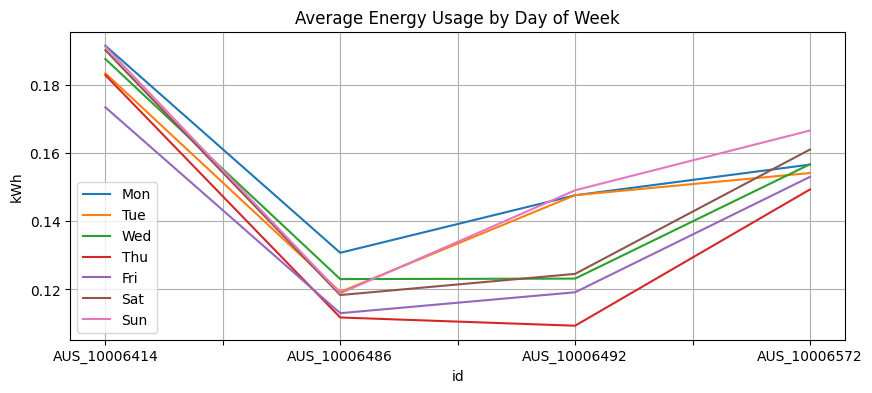

In [55]:
# Weekly pattern

avg_daily = df.groupby(["id", "dayofweek"])["target"].mean().unstack(0)
avg_daily = avg_daily.T
avg_daily.columns = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

avg_daily.plot(figsize=(10, 4), title="Average Energy Usage by Day of Week")
plt.ylabel("kWh")
plt.grid(True)
plt.show()

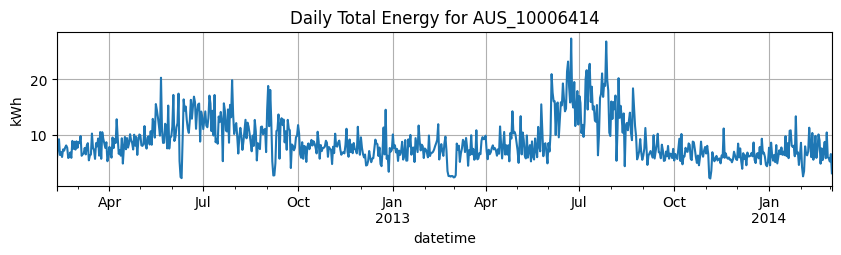

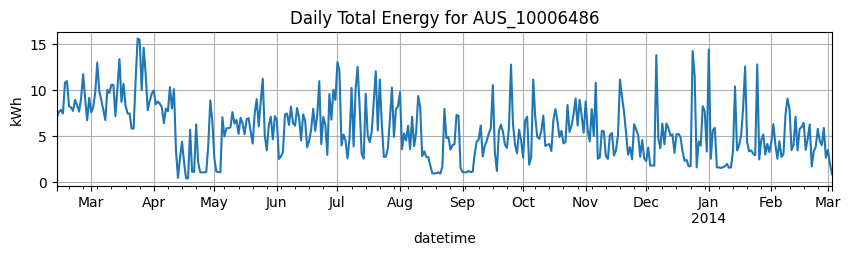

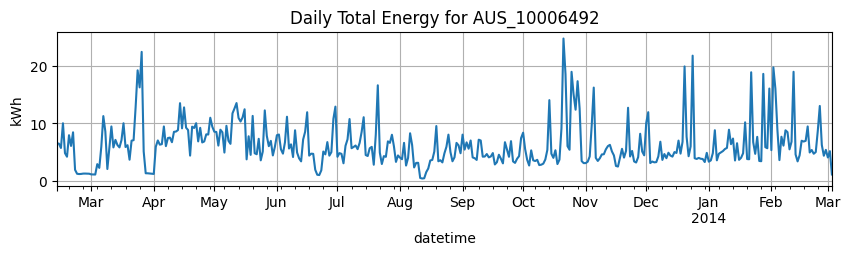

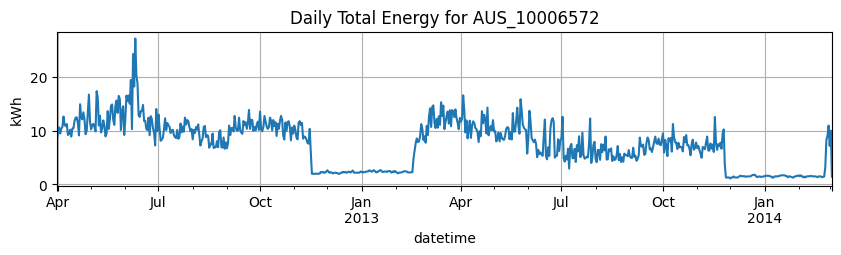

In [56]:
for hid in df["id"].unique():
    daily_series = df[df["id"] == hid].set_index("datetime").resample("D")["target"].sum()
    daily_series.plot(figsize=(10, 2), title=f"Daily Total Energy for {hid}")
    plt.ylabel("kWh")
    plt.grid(True)
    plt.show()

# old code below

In [28]:
df_30m_aus_subset_of_4_copy = df_30m_aus_subset_of_4.copy()
df_30m_aus_subset_of_4_copy["hour"] = df_30m_aus_subset_of_4["datetime"].dt.hour
df_30m_aus_subset_of_4_copy["day_of_week"] = df_30m_aus_subset_of_4["datetime"].dt.dayofweek
df_30m_aus_subset_of_4_copy["date"] = df_30m_aus_subset_of_4["datetime"].dt.date


In [29]:
df_30m_aus_subset_of_4_copy

,datetime,id,target,category,hour,day_of_week,date
0,2012-02-10 08:00:00,AUS_10006414,0.141,30m,8,4,2012-02-10
1,2012-02-10 08:30:00,AUS_10006414,0.088,30m,8,4,2012-02-10
2,2012-02-10 09:00:00,AUS_10006414,0.078,30m,9,4,2012-02-10
3,2012-02-10 09:30:00,AUS_10006414,0.151,30m,9,4,2012-02-10
4,2012-02-10 10:00:00,AUS_10006414,0.146,30m,10,4,2012-02-10
...,...,...,...,...,...,...,...
106668,2014-03-03 05:30:00,AUS_10006572,0.061,30m,5,0,2014-03-03
106669,2014-03-03 06:00:00,AUS_10006572,0.087,30m,6,0,2014-03-03
106670,2014-03-03 06:30:00,AUS_10006572,0.080,30m,6,0,2014-03-03
106671,2014-03-03 07:00:00,AUS_10006572,0.087,30m,7,0,2014-03-03


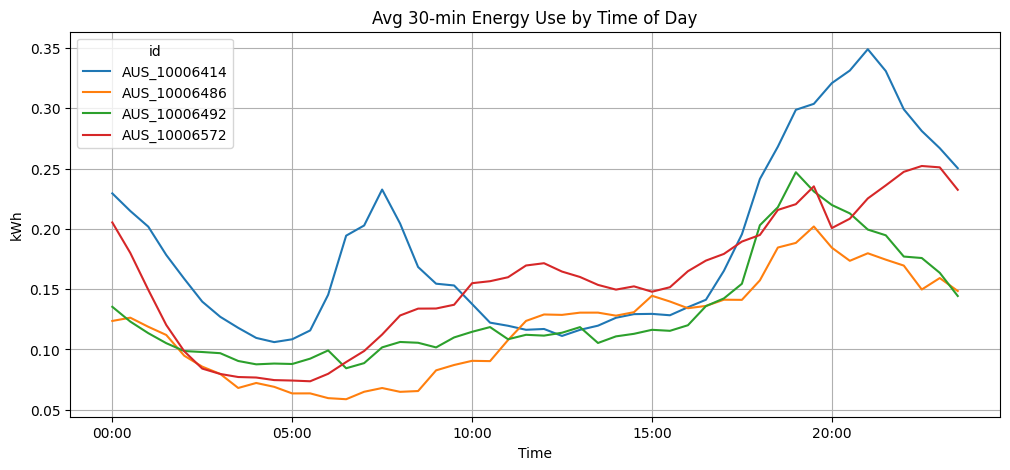

In [30]:
avg_profile = df_30m_aus_subset_of_4_copy.groupby(["id", df_30m_aus_subset_of_4_copy["datetime"].dt.strftime("%H:%M")])["target"].mean().unstack(0)
avg_profile.plot(figsize=(12, 5), title="Avg 30-min Energy Use by Time of Day")
plt.ylabel("kWh")
plt.xlabel("Time")
plt.grid(True)
plt.show()


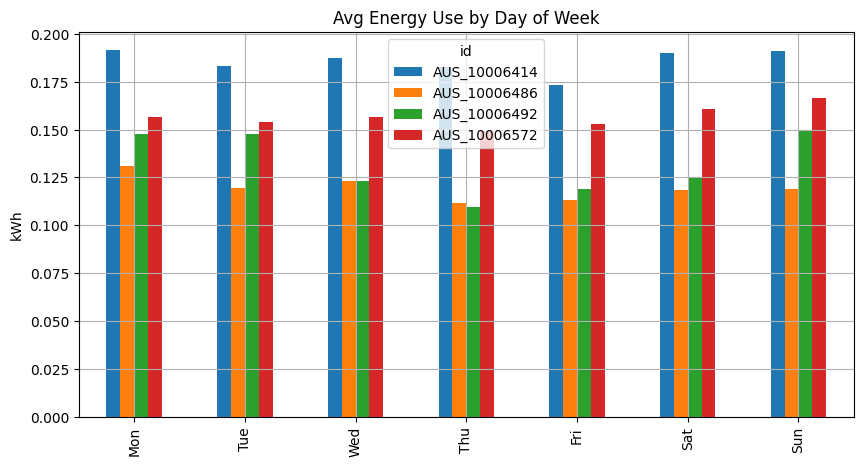

In [31]:
dow_avg = df_30m_aus_subset_of_4_copy.groupby(["id", "day_of_week"])["target"].mean().unstack(0)
dow_avg.index = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
dow_avg.plot(kind="bar", figsize=(10, 5), title="Avg Energy Use by Day of Week")
plt.ylabel("kWh")
plt.grid(True)
plt.show()


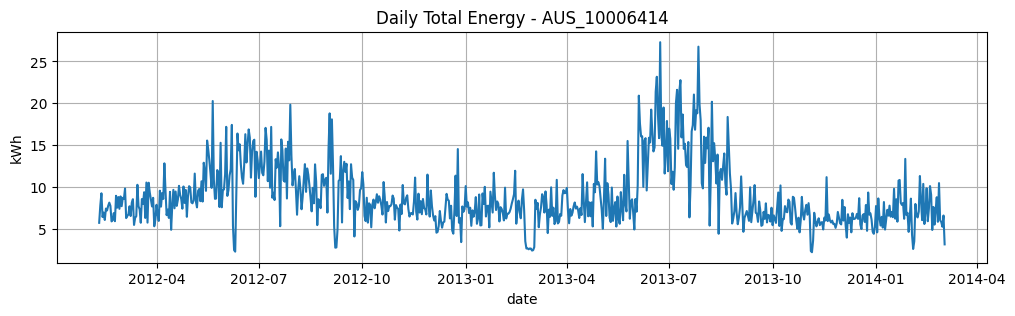

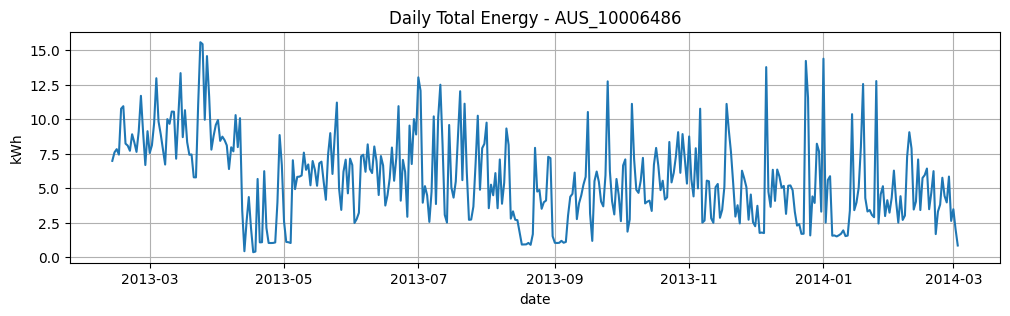

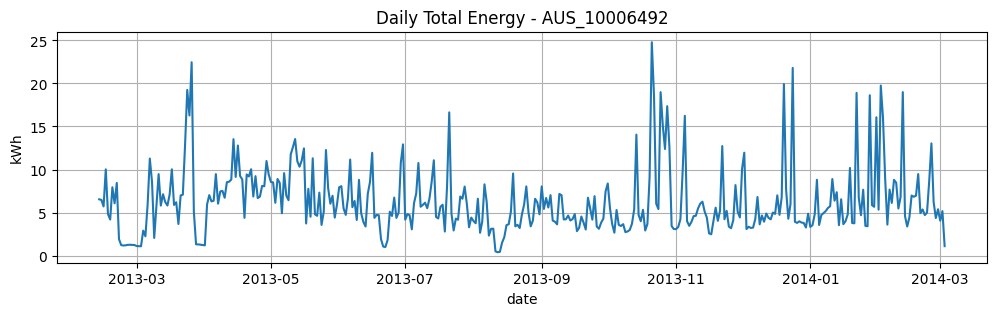

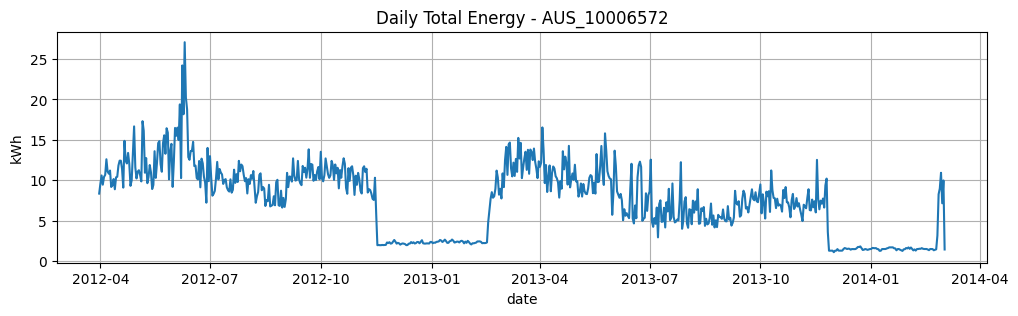

In [32]:
for household_id in df_30m_aus_subset_of_4_copy["id"].unique():
    df_temp = df_30m_aus_subset_of_4_copy[df_30m_aus_subset_of_4["id"] == household_id]
    df_daily = df_temp.groupby("date")["target"].sum()
    df_daily.plot(figsize=(12, 3), title=f"Daily Total Energy - {household_id}")
    plt.ylabel("kWh")
    plt.grid(True)
    plt.show()


In [ ]:

df_30m_aus = dd.read_parquet("TUDelft-Electricity-Consumption-1.0/30m_resolution_aus/aus_30m.parquet")
df_30m_aus["datetime"] = dd.to_datetime(df_30m_aus["datetime"])
df_30m_aus["time"] = df_30m_aus["datetime"].dt.time
df_30m_aus["date"] = df_30m_aus["datetime"].dt.date
df_30m_aus['hour_min'] = df_30m_aus["datetime"].dt.strftime("%H:%M")


df_30m_ge = dd.read_parquet("TUDelft-Electricity-Consumption-1.0/30m_resolution_ge/ge_30m.parquet")
df_30m_ge["datetime"] = dd.to_datetime(df_30m_ge["datetime"])
df_30m_ge["time"] = df_30m_ge["datetime"].dt.time
df_30m_ge["date"] = df_30m_ge["datetime"].dt.date
df_30m_ge['hour_min'] = df_30m_ge["datetime"].dt.strftime("%H:%M")

df_30m_uk = dd.read_parquet("TUDelft-Electricity-Consumption-1.0/30m_resolution_uk/uk_30m.parquet")
df_30m_uk["datetime"] = dd.to_datetime(df_30m_uk["datetime"])
df_30m_uk["time"] = df_30m_uk["datetime"].dt.time
df_30m_uk["date"] = df_30m_uk["datetime"].dt.date
df_30m_uk['hour_min'] = df_30m_uk["datetime"].dt.strftime("%H:%M")

In [3]:
print(len(df_30m_aus))
print(len(df_30m_ge))
print(len(df_30m_uk))

347213367
232538
168323651


In [4]:
df_30m_aus.dtypes  
df_30m_aus.columns  

Index(['datetime', 'id', 'target', 'category', 'time', 'date', 'hour_min'], dtype='object')

In [4]:
df_30m_aus.head(10)

,datetime,id,target,category,time,date,hour_min
0,2012-02-10 08:00:00,AUS_10006414,0.141,30m,08:00:00,2012-02-10,08:00
1,2012-02-10 08:30:00,AUS_10006414,0.088,30m,08:30:00,2012-02-10,08:30
2,2012-02-10 09:00:00,AUS_10006414,0.078,30m,09:00:00,2012-02-10,09:00
3,2012-02-10 09:30:00,AUS_10006414,0.151,30m,09:30:00,2012-02-10,09:30
4,2012-02-10 10:00:00,AUS_10006414,0.146,30m,10:00:00,2012-02-10,10:00
5,2012-02-10 10:30:00,AUS_10006414,0.077,30m,10:30:00,2012-02-10,10:30
6,2012-02-10 11:00:00,AUS_10006414,0.052,30m,11:00:00,2012-02-10,11:00
7,2012-02-10 11:30:00,AUS_10006414,0.055,30m,11:30:00,2012-02-10,11:30
8,2012-02-10 12:00:00,AUS_10006414,0.055,30m,12:00:00,2012-02-10,12:00
9,2012-02-10 12:30:00,AUS_10006414,0.252,30m,12:30:00,2012-02-10,12:30


In [5]:
df_30m_ge.head(10)

,datetime,id,target,category,time,date,hour_min
0,2015-05-21 15:30:00,GE_1,0.157,30m,15:30:00,2015-05-21,15:30
1,2015-05-21 16:00:00,GE_1,0.584,30m,16:00:00,2015-05-21,16:00
2,2015-05-21 16:30:00,GE_1,0.545,30m,16:30:00,2015-05-21,16:30
3,2015-05-21 17:00:00,GE_1,0.677,30m,17:00:00,2015-05-21,17:00
4,2015-05-21 17:30:00,GE_1,0.351,30m,17:30:00,2015-05-21,17:30
5,2015-05-21 18:00:00,GE_1,0.325,30m,18:00:00,2015-05-21,18:00
6,2015-05-21 18:30:00,GE_1,0.258,30m,18:30:00,2015-05-21,18:30
7,2015-05-21 19:00:00,GE_1,0.330,30m,19:00:00,2015-05-21,19:00
8,2015-05-21 19:30:00,GE_1,0.250,30m,19:30:00,2015-05-21,19:30
9,2015-05-21 20:00:00,GE_1,0.270,30m,20:00:00,2015-05-21,20:00


In [6]:
df_30m_uk.head(10)

,datetime,id,target,category,time,date,hour_min
0,2012-10-12 00:30:00,uk_MAC000002,0.0,30m,00:30:00,2012-10-12,00:30
1,2012-10-12 01:00:00,uk_MAC000002,0.0,30m,01:00:00,2012-10-12,01:00
2,2012-10-12 01:30:00,uk_MAC000002,0.0,30m,01:30:00,2012-10-12,01:30
3,2012-10-12 02:00:00,uk_MAC000002,0.0,30m,02:00:00,2012-10-12,02:00
4,2012-10-12 02:30:00,uk_MAC000002,0.0,30m,02:30:00,2012-10-12,02:30
5,2012-10-12 03:00:00,uk_MAC000002,0.0,30m,03:00:00,2012-10-12,03:00
6,2012-10-12 03:30:00,uk_MAC000002,0.0,30m,03:30:00,2012-10-12,03:30
7,2012-10-12 04:00:00,uk_MAC000002,0.0,30m,04:00:00,2012-10-12,04:00
8,2012-10-12 04:30:00,uk_MAC000002,0.0,30m,04:30:00,2012-10-12,04:30
9,2012-10-12 05:00:00,uk_MAC000002,0.0,30m,05:00:00,2012-10-12,05:00


In [7]:
df_30m_aus['datetime'].min().compute(), df_30m_aus['datetime'].max().compute()


(Timestamp('2011-10-06 12:30:00'), Timestamp('2014-03-04 08:00:00'))

In [8]:
df_30m_ge['datetime'].min().compute(), df_30m_ge['datetime'].max().compute()


(Timestamp('2015-04-15 09:00:00'), Timestamp('2019-05-01 22:00:00'))

In [4]:
df_30m_uk['datetime'].min().compute(), df_30m_uk['datetime'].max().compute()


(Timestamp('2011-11-23 09:00:00'), Timestamp('2014-02-28 00:00:00'))

In [4]:
print(df_30m_aus['id'].nunique().compute())
print(df_30m_ge['id'].nunique().compute())
print(df_30m_uk['id'].nunique().compute())

13735
6
5566


In [ ]:
# Germany, 30mins

df = dd.read_parquet("TUDelft-Electricity-Consumption-1.0/30m_resolution_ge/ge_30m.parquet")
df = df.compute()
df['datetime'] = pd.to_datetime(df['datetime'])
print(df.info())
print(df.head())

print("Columns:", df.columns.tolist())
print("Unique IDs:", df['id'].nunique())
print("Time range:", df['datetime'].min(), "to", df['datetime'].max())
print(df.isna().sum())
print(df.describe())
print(df.dtypes)
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232538 entries, 0 to 232537
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   datetime  232538 non-null  datetime64[ns]
 1   id        232538 non-null  string        
 2   target    232538 non-null  float64       
 3   category  232538 non-null  string        
dtypes: datetime64[ns](1), float64(1), string(2)
memory usage: 8.6 MB
None
             datetime    id  target category
0 2015-05-21 15:30:00  GE_1   0.157      30m
1 2015-05-21 16:00:00  GE_1   0.584      30m
2 2015-05-21 16:30:00  GE_1   0.545      30m
3 2015-05-21 17:00:00  GE_1   0.677      30m
4 2015-05-21 17:30:00  GE_1   0.351      30m
Columns: ['datetime', 'id', 'target', 'category']
Unique IDs: 6
Time range: 2015-04-15 09:00:00 to 2019-05-01 22:00:00
datetime    0
id          0
target      0
category    0
dtype: int64
                            datetime         target
count                  

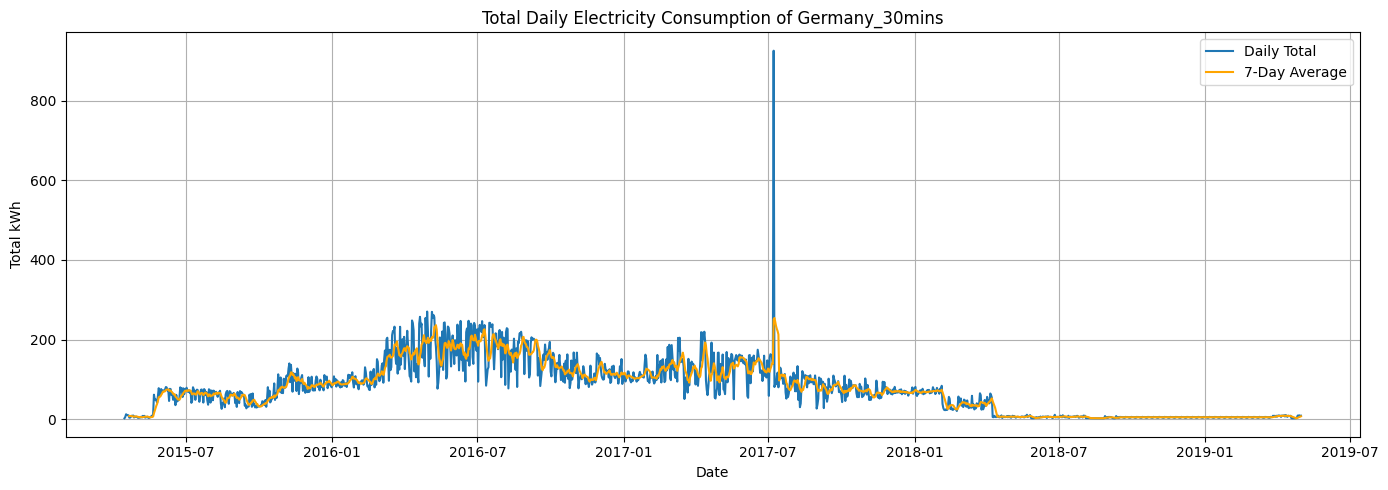

In [16]:
daily_total = df.resample('D', on='datetime')['target'].sum()

plt.figure(figsize=(14, 5))
sns.lineplot(x=daily_total.index, y=daily_total.values, label="Daily Total")
sns.lineplot(x=daily_total.index, y=daily_total.rolling(7).mean(), label="7-Day Average", color='orange')
plt.title("Total Daily Electricity Consumption of Germany_30mins")
plt.xlabel("Date"); plt.ylabel("Total kWh")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

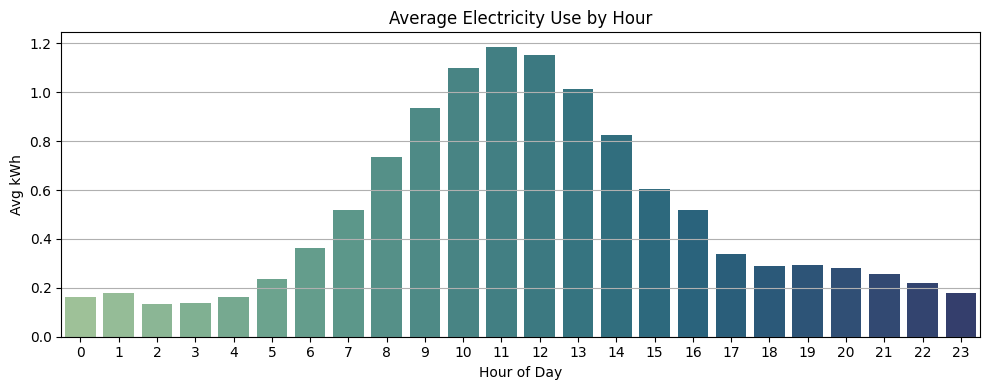

In [18]:
df["hour"] = df_30m_ge["datetime"].dt.hour
hourly_avg = df.groupby('hour')['target'].mean()
plt.figure(figsize=(10, 4))
sns.barplot(x=hourly_avg.index, y=hourly_avg.values, palette="crest")
plt.title("Average Electricity Use by Hour")
plt.xlabel("Hour of Day"); plt.ylabel("Avg kWh")
plt.grid(axis='y'); plt.tight_layout(); plt.show()

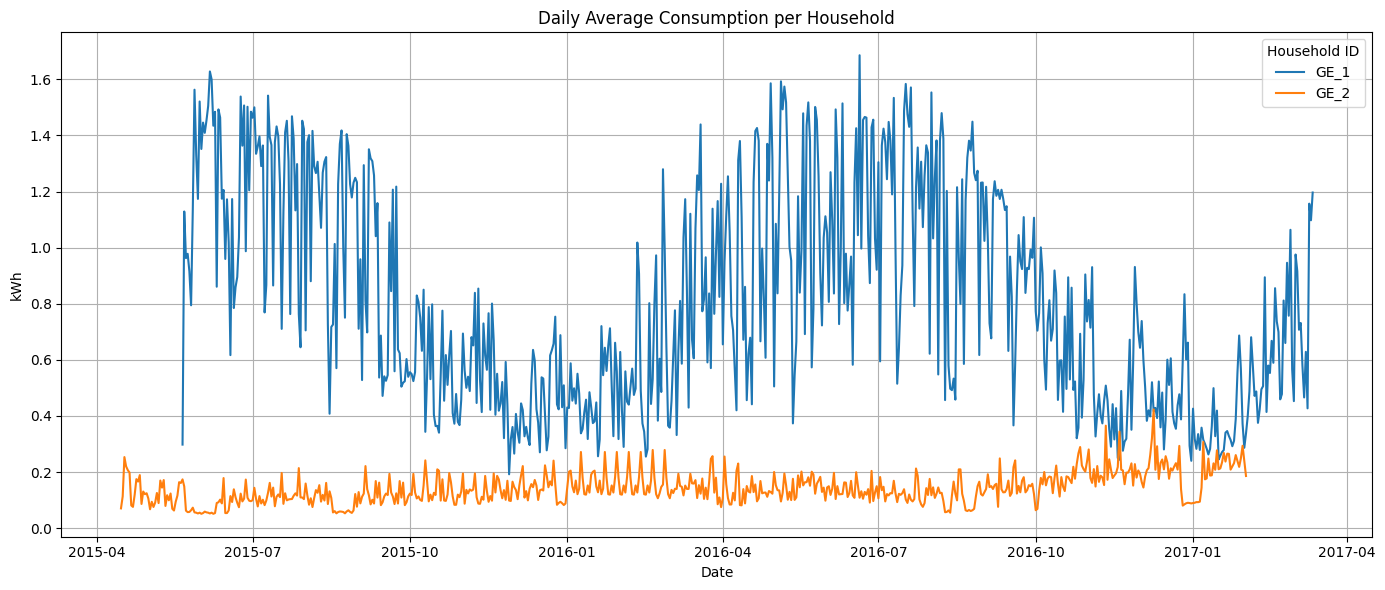

In [21]:
sample_ids = df['id'].unique()[:2]

plt.figure(figsize=(14, 6))
for uid in sample_ids:
    daily_avg = df[df['id'] == uid].set_index('datetime').resample('D')['target'].mean()
    sns.lineplot(x=daily_avg.index, y=daily_avg.values, label=uid)

plt.title("Daily Average Consumption per Household")
plt.xlabel("Date"); plt.ylabel("kWh")
plt.legend(title="Household ID"); plt.grid(True); plt.tight_layout(); plt.show()

In [22]:
df2 = dd.read_parquet("TUDelft-Electricity-Consumption-1.0/30m_resolution_uk/uk_30m.parquet")
df2 = df2.compute()
df2['datetime'] = pd.to_datetime(df2['datetime'])
print(df2.info())
print(df2.head())

print("Columns:", df2.columns.tolist())
print("Unique IDs:", df2['id'].nunique())
print("Time range:", df2['datetime'].min(), "to", df2['datetime'].max())
print(df2.isna().sum())
print(df2.describe())
print(df2.dtypes)
print(df2.head())


<class 'pandas.core.frame.DataFrame'>
Index: 168323651 entries, 0 to 7965638
Data columns (total 4 columns):
 #   Column    Dtype         
---  ------    -----         
 0   datetime  datetime64[ns]
 1   id        string        
 2   target    float64       
 3   category  string        
dtypes: datetime64[ns](1), float64(1), string(2)
memory usage: 8.6 GB
None
             datetime            id  target category
0 2012-10-12 00:30:00  uk_MAC000002     0.0      30m
1 2012-10-12 01:00:00  uk_MAC000002     0.0      30m
2 2012-10-12 01:30:00  uk_MAC000002     0.0      30m
3 2012-10-12 02:00:00  uk_MAC000002     0.0      30m
4 2012-10-12 02:30:00  uk_MAC000002     0.0      30m
Columns: ['datetime', 'id', 'target', 'category']
Unique IDs: 5566
Time range: 2011-11-23 09:00:00 to 2014-02-28 00:00:00
datetime         0
id               0
target      614425
category         0
dtype: int64


: 